# Getting data

In [2]:
import pandas as pd
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

start = '2011-10-01'
end = '2011-10-30'
weekdays =['Pon', 'Wt', 'Sr', 'Czw', 'Pt', 'Sb', 'Nd']

def dzienTyg(dzienNum):
    if dzienNum == 0:
        return 'Pon'
    elif dzienNum == 1:
        return 'Wt'
    elif dzienNum == 2:
        return 'Sr'
    elif dzienNum == 3:
        return 'Czw'
    elif dzienNum == 4:
        return 'Pt'
    elif dzienNum == 5:
        return 'Sb'
    elif dzienNum == 6:
        return 'Nd'
    else:
        return 'Blad'
def date_fromisofromat(dt):
    y = int(dt[0: 4])
    m = int(dt[5: 7])
    d = int(dt[8:10])
    return date(y,m,d)

def combineData(start, end):
    startDt = date_fromisofromat(start)
    endDt   = date_fromisofromat(end)
    d = datetime.timedelta(days=1)
    m = relativedelta(months=+1)

    in_table = pd.read_csv(filepath_or_buffer= '../Data/20100301-20100331.csv', 
                       sep=';', 
                       engine='python')
    in_table= in_table.iloc[0:0] #drop all rows, leave columns

    while(startDt <= endDt):
        fileName = str(startDt).replace('-','') + '-' + str(startDt + m - d).replace('-','') + '.csv'
        in_table1 = pd.read_csv(filepath_or_buffer= '../Data/' +fileName, 
                           sep=';', 
                           engine='python')
        in_table = in_table.append(in_table1,ignore_index=True)
        startDt = startDt + relativedelta(months=+1)

    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].apply(lambda x: x.replace(',','.'))
    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].astype(float)
    in_table['Rok']     = in_table['Data'].apply(lambda x: x[0: 4]).astype(int)
    in_table['Miesiac'] = in_table['Data'].apply(lambda x: x[5: 7]).astype(int)
    in_table['Dzien']   = in_table['Data'].apply(lambda x: x[8:10]).astype(int)
    # in_table['Godz_mies']=(in_table['Dzien']-1)*24 +in_table['Godzina']
    return in_table
#     plt.show()
# Data, Godzina, Krajowe zapotrzebowanie na moc, Sumaryczna generacja JWCD, 
# Generacja PI, Generacja IRZ, Sumaryczna generacja nJWCD, 
# Krajowe saldo wymiany międzysystemowej równoległej, 
# Krajowe saldo wymiany międzysystemowej nierównoległej, 

dataAll = combineData(start, end)
dataAll = dataAll.loc[dataAll['Godzina'] != '2A']

dataAll['Godzina'] = dataAll['Godzina'].apply(
    lambda x: (int(str(x)))
)
dataAll['weekDayNum'] = dataAll['Data'].apply(
    lambda x: (date_fromisofromat(x).weekday())
)
dataAll['weekDay'] = dataAll['Data'].apply(
    lambda x: dzienTyg(date_fromisofromat(x).weekday())
)
dataAll['DataGodz'] = pd.to_datetime(dataAll['Data']) 

dataAll['DataGodz'] = dataAll['DataGodz'] + dataAll['Godzina'].apply(
    lambda x: relativedelta(hours=x)
)
    
modelData = dataAll[['Krajowe zapotrzebowanie na moc']]

#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz']] 
modelData2.set_index('DataGodz')
modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

modelData2

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


,Krajowe zapotrzebowanie na moc,DataGodz
DataGodz,,
2011-10-01 01:00:00,15408.288,2011-10-01 01:00:00
2011-10-01 02:00:00,14673.075,2011-10-01 02:00:00
2011-10-01 03:00:00,14309.563,2011-10-01 03:00:00
2011-10-01 04:00:00,14259.925,2011-10-01 04:00:00
2011-10-01 05:00:00,14191.138,2011-10-01 05:00:00
...,...,...
2011-10-31 20:00:00,20140.075,2011-10-31 20:00:00
2011-10-31 21:00:00,19435.238,2011-10-31 21:00:00
2011-10-31 22:00:00,18105.900,2011-10-31 22:00:00


In [ ]:
a_row = pd.Series([(15019.638+14379.763)/2, '2011-03-27 02:00:00'])
row_df = pd.DataFrame([a_row])
row_df.columns = modelData2.columns
row_df.index = pd.DatetimeIndex(row_df['DataGodz'])
modelData2 = pd.concat([row_df, modelData2])
modelData2

# Seasonal ARIMA

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose


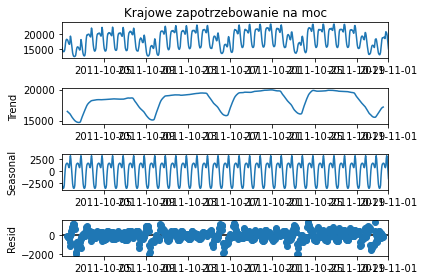

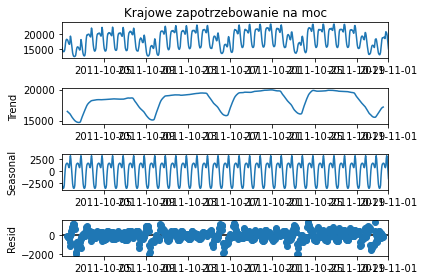

In [4]:
# modelData2[modelData2.index > '2011-03-27' ]
modelData2=modelData2.asfreq('H')
res = seasonal_decompose(modelData2['Krajowe zapotrzebowanie na moc'], model = 'add')
res.plot()

In [54]:
start_calc = (datetime.datetime.now())
m1 = auto_arima(modelData2['Krajowe zapotrzebowanie na moc'], 
           seasonal = True, 
           m=3, 
           maxiter = 10,
           trace = True)#.summary()
calc_time = datetime.datetime.now() - start_calc
print(calc_time)

Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=11505.352, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=12229.785, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=11668.159, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=11733.505, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=12227.786, Time=0.02 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,1)[3] intercept   : AIC=11503.139, Time=0.39 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,0)[3] intercept   : AIC=11501.442, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,0)[3] intercept   : AIC=11502.826, Time=0.39 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[3] intercept   : AIC=11582.297, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[3] intercept   : AIC=11561.204, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[3] intercept   : AIC=11587.794, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,0)[3]             : AIC=11499.514, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,0)[3]             : AIC=11500.895, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,1)[3]             : AIC=11501.202, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[3]             : AIC=11503.408, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[3]             : AIC=11580.325, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[3]             : AIC=11559.203, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[3]             : AIC=11585.812, Time=0.12 sec

Best model:  ARIMA(2,1,2)(0,0,0)[3]          
Total fit time: 4.222 seconds
0:00:04.235997


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [76]:
def create_model(dane, sezon, maxiter = 20):
    
    #auto ARIMA
    m = auto_arima(modelData2['Krajowe zapotrzebowanie na moc'], 
           seasonal = True, 
           m=sezon, 
           maxiter = maxiter,
           trace = True)#.summary()
    order = m.get_params()['order']
    seasonal_order = m1.get_params()['seasonal_order']
    print(order)
    print(seasonal_order)
    #SARIMAX
    model = SARIMAX(dane, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse')
    model_fit = model.fit() 
    
    return model_fit
    


In [69]:
model = SARIMAX(
    modelData2['Krajowe zapotrzebowanie na moc'], 
    order = (0, 1, 2),
    seasonal_order=(1,0,2,168),  #p - AR, d - diff (trend), q - MA, s - season
    initialization='approximate_diffuse'
)
# dir(model)

In [77]:
print(create_model(modelData2['Krajowe zapotrzebowanie na moc'],2))

Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=11575.175, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=12229.785, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=11690.829, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=11610.155, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=12227.786, Time=0.02 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=11573.191, Time=0.60 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=11586.812, Time=0.51 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=11565.034, Time=0.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,2)[2] intercept   : AIC=11551.498, Time=0.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=11468.651, Time=1.50 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,1)(2,0,1)[2] intercept   : AIC=11544.249, Time=0.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,2)[2] intercept   : AIC=11556.487, Time=0.98 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,2)[2] intercept   : AIC=11581.057, Time=1.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,2)[2] intercept   : AIC=12028.958, Time=0.84 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,2)[2]             : AIC=11437.592, Time=0.90 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,2)[2]             : AIC=11549.509, Time=0.61 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,1)[2]             : AIC=11542.256, Time=0.59 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,1)(1,0,1)[2]             : AIC=11573.188, Time=0.46 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,2)[2]             : AIC=11554.671, Time=0.70 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,2)[2]             : AIC=11579.376, Time=1.00 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,2)[2]             : AIC=11987.794, Time=0.61 sec

Best model:  ARIMA(1,1,1)(2,0,2)[2]          
Total fit time: 14.837 seconds
(1, 1, 1)
(0, 0, 0, 3)


In [ ]:
# fitting
time0 = datetime.datetime.now()
model_fit = model.fit() #disp=0)
print('Fitting model execution time: ' + str(datetime.datetime.now() - time0))

In [ ]:

modelData2['Krajowe zapotrzebowanie na moc'].plot()
# modelData2['Krajowe zapotrzebowanie na moc'][1200:].plot()
pred = model_fit.forecast(300, dynamic=True)
pred.plot()